### Fine-tuning
In this notebook we focus on fine-tuning Lag-Llama on all the sensor data 1 from FOO1 dataset

#### Loading lib and datasets

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from itertools import islice
import torch
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from tqdm.autonotebook import tqdm
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/var/folders/gg/9f69dtmn6vjbk9_cmv3vx3lc0000gn/T/ipykernel_26829/2026785699.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [16]:
df = pd.read_csv('/Users/junbo/studium/ma/CMAPSS Data/train_FD001.txt', index_col=0, sep=" ", header=None)
column_indices = np.arange(df.shape[1]-1).tolist()

index_columns_names =  ["cycle"]
op_settings_columns = ["op_setting_"+str(i) for i in range(1,4)]
sensor_columns =["sensor_"+str(i) for i in range(1,22)]
new_names = index_columns_names + op_settings_columns + sensor_columns

old_names = df.columns[column_indices]
df.rename(columns=dict(zip(old_names, new_names)), inplace=True)
df.index.names = ['engine']
df.drop([26, 27], axis=1, inplace=True)
df_sensor_14 = df[['cycle', 'sensor_14']]
df_sensor_14 = df_sensor_14.reset_index()
pivot_df = df_sensor_14.pivot(index='cycle', columns='engine', values='sensor_14')

In [17]:
pivot_df

engine,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
cycle,,,,,,,,,,,,,,,,,,,,,
1,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
2,8131.49,8131.09,8137.38,8129.53,8153.04,8126.01,8148.24,8120.18,8148.23,8142.57,...,8131.08,8135.54,8141.41,8126.19,8151.85,8136.21,8131.43,8147.03,8132.70,8143.56
3,8133.23,8140.58,8137.20,8131.24,8148.42,8125.49,8148.83,8122.29,8140.94,8136.85,...,8134.12,8137.39,8140.79,8130.38,8148.79,8134.72,8129.52,8149.19,8132.44,8146.62
4,8133.83,8140.44,8139.35,8132.90,8148.81,8117.06,8150.30,8123.80,8145.41,8136.62,...,8127.29,8135.96,8144.72,8126.63,8148.08,8134.52,8131.14,8156.01,8133.19,8146.60
5,8133.80,8136.67,8135.99,8126.94,8147.69,8124.10,8149.40,8118.15,8145.92,8138.95,...,8132.13,8138.76,8144.23,8129.45,8144.88,8135.34,8130.03,8148.47,8132.30,8141.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
import pandas as pd

url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df_wide = pd.read_csv(url_wide, index_col=0, parse_dates=True)
df_wide

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708
...,...,...,...,...,...,...,...,...,...,...
2021-01-10 19:00:00,0.7328,0.6937,-0.3679,-0.6389,-1.3643,0.1667,0.3918,-0.4162,0.9811,1.2349
2021-01-10 20:00:00,0.4957,0.7043,-0.5553,-0.8691,-1.8283,0.0413,0.8977,-0.5412,1.0969,1.1525
2021-01-10 21:00:00,-0.1209,0.5297,-0.7084,-1.0384,-2.0439,0.0534,1.3973,-0.6366,1.1286,1.1485
2021-01-10 22:00:00,-0.5072,0.5816,-0.5735,-1.3990,-2.1105,-0.0674,1.3225,-0.5672,1.0786,1.3248


<Axes: xlabel='cycle'>

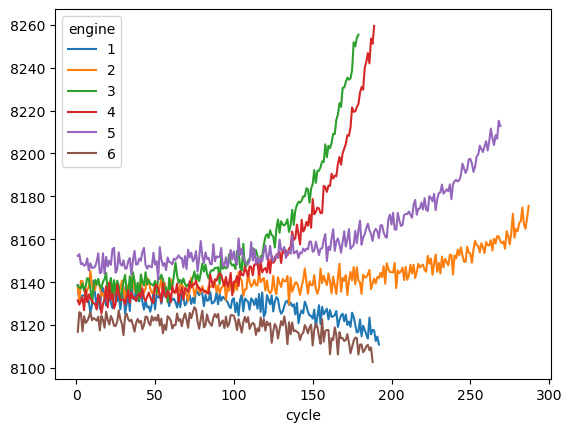

In [13]:
# quick vis
pivot_df[[1,2,3,4,5,6]].plot()

In [14]:
pivot_df = pivot_df.dropna() # truncate, only deal with the first 128 timestamps -- starting from 129th timestamp failure occured for one trajectory
pivot_df.index.name = 'timestamps'
pivot_df.index = pd.to_datetime(pivot_df.index, origin='1970-01-01', unit='h')
pivot_df

engine,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
timestamps,,,,,,,,,,,,,,,,,,,,,
1970-01-01 01:00:00,8138.62,8137.72,8138.40,8131.50,8152.22,8116.86,8141.69,8123.47,8149.16,8137.61,...,8134.25,8136.55,8139.06,8120.76,8153.89,8133.36,8130.81,8150.69,8131.23,8146.76
1970-01-01 02:00:00,8131.49,8131.09,8137.38,8129.53,8153.04,8126.01,8148.24,8120.18,8148.23,8142.57,...,8131.08,8135.54,8141.41,8126.19,8151.85,8136.21,8131.43,8147.03,8132.70,8143.56
1970-01-01 03:00:00,8133.23,8140.58,8137.20,8131.24,8148.42,8125.49,8148.83,8122.29,8140.94,8136.85,...,8134.12,8137.39,8140.79,8130.38,8148.79,8134.72,8129.52,8149.19,8132.44,8146.62
1970-01-01 04:00:00,8133.83,8140.44,8139.35,8132.90,8148.81,8117.06,8150.30,8123.80,8145.41,8136.62,...,8127.29,8135.96,8144.72,8126.63,8148.08,8134.52,8131.14,8156.01,8133.19,8146.60
1970-01-01 05:00:00,8133.80,8136.67,8135.99,8126.94,8147.69,8124.10,8149.40,8118.15,8145.92,8138.95,...,8132.13,8138.76,8144.23,8129.45,8144.88,8135.34,8130.03,8148.47,8132.30,8141.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-06 04:00:00,8133.82,8135.96,8161.91,8152.25,8151.19,8111.71,8149.35,8120.20,8161.35,8148.12,...,8121.79,8138.34,8140.56,8130.94,8149.14,8137.66,8144.46,8143.45,8134.37,8140.37
1970-01-06 05:00:00,8126.33,8142.91,8161.30,8148.95,8149.66,8117.13,8154.28,8122.48,8165.90,8142.27,...,8122.34,8137.62,8141.95,8133.91,8151.12,8139.45,8148.09,8146.33,8129.70,8140.17
1970-01-06 06:00:00,8130.94,8136.69,8156.20,8149.92,8151.84,8120.48,8152.25,8123.39,8163.95,8145.09,...,8117.73,8134.56,8149.01,8136.16,8150.02,8131.43,8143.70,8144.57,8135.46,8145.54


<Axes: xlabel='timestamps'>

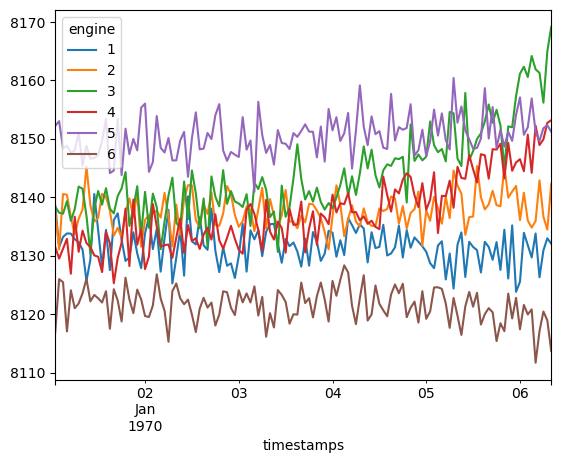

In [15]:
# quick vis
pivot_df[[1,2,3,4,5,6]].plot()

In [6]:
# convert df to training and testing datasets
prediction_length = 24
pivot_df = df_wide
train_data = [{"start": pivot_df.index[0], "target": pivot_df[i].values[:-prediction_length]} for i in pivot_df.columns] # (128 - 24) by 100
test_data = [{"start": pivot_df.index[0], "target": pivot_df[i].values} for i in pivot_df.columns] # 128 by 100

train_ds = ListDataset(data_iter=train_data, freq='1H') # training dataset
test_ds = ListDataset(data_iter=test_data, freq='1H') # testing dataset

#### loading the ckpt and building LagLlamaEstimator as the estimator

In [7]:
prediction_length = 24 # default
num_samples = 10 # default - probability forecasting
context_length = 32
device = "mps"

ckpt = torch.load("lag-llama.ckpt", map_location=torch.device(device))

estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=10e-4, # training params

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        }, #  why commented out?

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 20,}, # <- lightning trainer arguments
    )

In [8]:
predictor = estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type               | Params
------------------------------------------

Epoch 0: |          | 50/? [00:29<00:00,  1.68it/s, v_num=21]

Epoch 0, global step 50: 'train_loss' reached -0.07549 (best -0.07549), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:24<00:00,  2.02it/s, v_num=21]

Epoch 1, global step 100: 'train_loss' reached -0.64388 (best -0.64388), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:18<00:00,  2.75it/s, v_num=21]

Epoch 2, global step 150: 'train_loss' reached -0.78149 (best -0.78149), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:18<00:00,  2.66it/s, v_num=21]

Epoch 3, global step 200: 'train_loss' reached -0.90357 (best -0.90357), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:17<00:00,  2.87it/s, v_num=21]

Epoch 4, global step 250: 'train_loss' reached -1.14481 (best -1.14481), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:17<00:00,  2.80it/s, v_num=21]

Epoch 5, global step 300: 'train_loss' reached -1.16555 (best -1.16555), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:19<00:00,  2.60it/s, v_num=21]

Epoch 6, global step 350: 'train_loss' reached -1.33845 (best -1.33845), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:17<00:00,  2.86it/s, v_num=21]

Epoch 7, global step 400: 'train_loss' reached -1.42828 (best -1.42828), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:17<00:00,  2.91it/s, v_num=21]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:17<00:00,  2.81it/s, v_num=21]

Epoch 9, global step 500: 'train_loss' reached -1.55833 (best -1.55833), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [00:18<00:00,  2.74it/s, v_num=21]

Epoch 10, global step 550: 'train_loss' reached -1.72749 (best -1.72749), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:18<00:00,  2.72it/s, v_num=21]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:17<00:00,  2.83it/s, v_num=21]

Epoch 12, global step 650: 'train_loss' reached -1.95323 (best -1.95323), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:18<00:00,  2.76it/s, v_num=21]

Epoch 13, global step 700: 'train_loss' reached -2.09142 (best -2.09142), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [00:17<00:00,  2.89it/s, v_num=21]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:17<00:00,  2.91it/s, v_num=21]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:18<00:00,  2.77it/s, v_num=21]

Epoch 16, global step 850: 'train_loss' reached -2.16611 (best -2.16611), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:17<00:00,  2.90it/s, v_num=21]

Epoch 17, global step 900: 'train_loss' reached -2.24954 (best -2.24954), saving model to '/Users/junbo/studium/ma/code/lag_llama_model/lightning_logs/version_21/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [00:21<00:00,  2.33it/s, v_num=21]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:19<00:00,  2.58it/s, v_num=21]

Epoch 19, global step 1000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: |          | 50/? [00:19<00:00,  2.58it/s, v_num=21]


#### getting the forecasts

In [9]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,
        predictor=predictor,
        num_samples=num_samples
    )
# forecasts = list(tqdm(forecast_it, total=len(test_ds)+len(train_ds), desc="Forecasting batches"))
# tss = list(tqdm(ts_it, total=len(test_ds)+len(train_ds), desc="Ground truth"))

# forecasts = list(tqdm(forecast_it, total=3, desc="Forecasting batches"))
# tss = list(tqdm(ts_it, total=3, desc="Ground truth"))

forecasts = list(forecast_it)
tss = list(ts_it)

In [10]:
ts_entry = tss[0]
np.array(ts_entry[:5]).reshape(-1,)

# first entry of test_ds
test_ds_entry = next(iter(test_ds))

# first 5 values
test_ds_entry["target"][:5]

# first entry of the forecast list
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 10
Dimension of samples: (10, 24)
Start date of the forecast window: 2021-01-10 00:00
Frequency of the time series: <Hour>


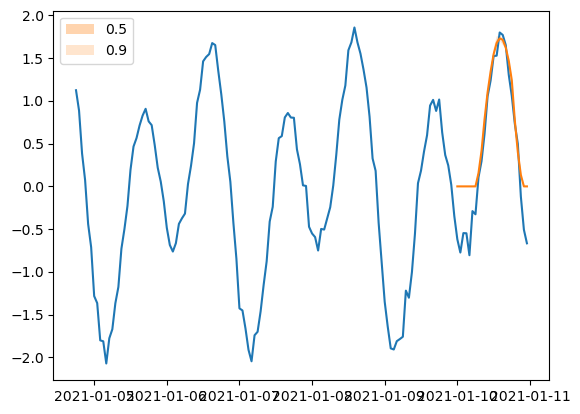

In [11]:
plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

#### plotting fine-tuned results

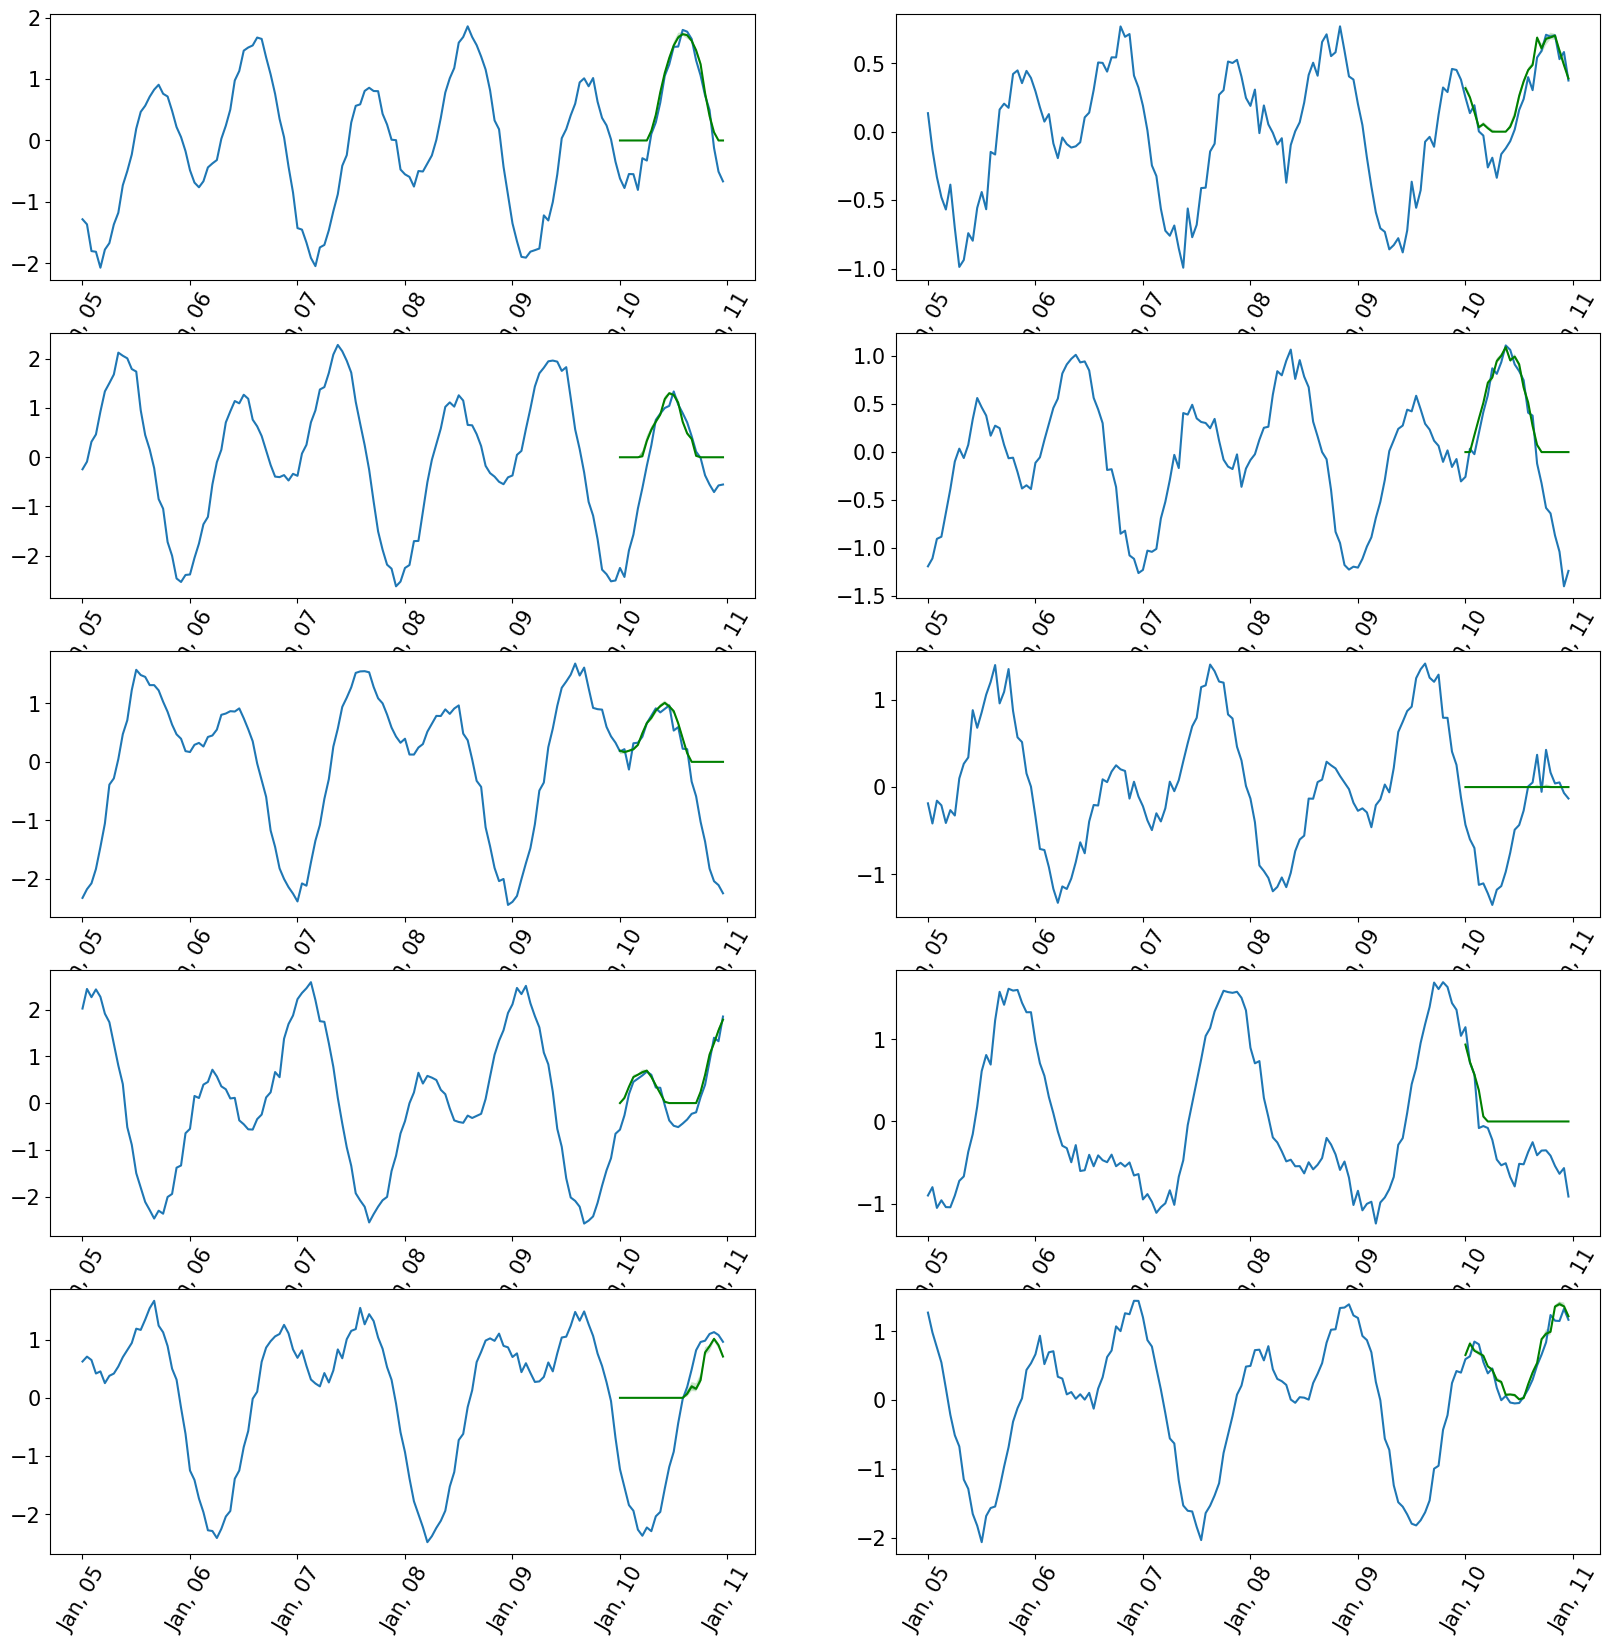

In [13]:
plt.figure(figsize=(20, 20))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 10):
    ax = plt.subplot(5, 2, idx+1)

    plt.plot(ts[-6 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)
 

In [14]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 10it [00:00, 170.59it/s]
/Users/junbo/miniconda3/envs/lag_llama/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [15]:
print("CRPS:", agg_metrics['mean_wQuantileLoss']) # CRPS: 0.0010361147587134459

CRPS: 0.6063143730923769
